<a href="https://colab.research.google.com/github/fxlmer/Skin-Diseases-Classification-Using-Machine-Learning/blob/master/Copy_of_Ex3_PJ61403_DenseNet121_FocalLoss_Ver2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Check GPU

In [1]:
!nvidia-smi

Wed Feb 24 07:14:58 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Import Libraries

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import models
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Activation, Flatten, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers
from tensorflow.keras.utils import Sequence
from imblearn.over_sampling import RandomOverSampler
from imblearn.keras import balanced_batch_generator
from keras.regularizers import l2

from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight, compute_sample_weight, compute_class_weight
from sklearn.metrics import balanced_accuracy_score, classification_report, confusion_matrix

import pandas as pd
import numpy as np
import os
import math
import itertools
from PIL import Image
from matplotlib import pyplot as plt

from pj61403_utils_functions_Ver2 import *

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from s

In [3]:
tf.compat.v1.disable_eager_execution()

# Hyperparameters

In [4]:
IMG_WIDTH = 224
IMG_HEIGHT = 224

EPOCHS = 100
NUM_CLASSES = 4
BATCH_SIZE = 32

LR = 3e-5

# Data

## Clone Data

In [5]:
!git clone https://github.com/EvilPickle-PCSHSPT/PJ61403_DATA_split_50-25-25

fatal: destination path 'PJ61403_DATA_split_50-25-25' already exists and is not an empty directory.


In [6]:
train_dir = '/content/PJ61403_DATA_split_50-25-25/Ver2/crop_split_classes_data_Ver2/train'

val_dir = '/content/PJ61403_DATA_split_50-25-25/Ver2/crop_split_classes_data_Ver2/cc_val'

test_dir = '/content/PJ61403_DATA_split_50-25-25/Ver2/crop_split_classes_data_Ver2/cc_test'

## Data Augmentation

In [7]:
train_aug = ImageDataGenerator(rescale=1./255,
                               rotation_range=360,
                               zoom_range=0.1,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               horizontal_flip=True,
                               vertical_flip=True,
                               fill_mode='reflect')

val_aug = ImageDataGenerator(rescale=1./255)

test_aug = ImageDataGenerator(rescale=1./255)

In [8]:
train_generator = train_aug.flow_from_directory(directory=train_dir,
                                                    target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                    batch_size=BATCH_SIZE,
                                                    shuffle=True,
                                                    class_mode ='categorical')

val_generator = val_aug.flow_from_directory(directory=val_dir,
                                                target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                batch_size=BATCH_SIZE,
                                                shuffle=True,
                                                class_mode='categorical')

test_generator = test_aug.flow_from_directory(directory=test_dir,
                                                  target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                  batch_size=1,
                                                  shuffle=False,
                                                  class_mode=None)

Found 242 images belonging to 4 classes.
Found 60 images belonging to 4 classes.
Found 63 images belonging to 4 classes.


# Model

## Base Model

In [9]:
!git clone https://github.com/fxlmer/JSTP22_Skin-Diseases-Classification-Using-Machine-Learning

fatal: destination path 'JSTP22_Skin-Diseases-Classification-Using-Machine-Learning' already exists and is not an empty directory.


In [10]:
def categorical_focal_loss(gamma=1.5, alpha=.25):
    """
    Softmax version of focal loss.
           m 
      FL = ∑  -alpha * (1 - p_o,c)^gamma * y_o,c * log(p_o,c)
          c=1
      where m = number of classes, c = class and o = observation
    Parameters:
      alpha -- the same as weighing factor in balanced cross entropy
      gamma -- focusing parameter for modulating factor (1-p)
    Default value:
      gamma -- 2.0 as mentioned in the paper
      alpha -- 0.25 as mentioned in the paper
    References:
        Official paper: https://arxiv.org/pdf/1708.02002.pdf
        https://www.tensorflow.org/api_docs/python/tf/keras/backend/categorical_crossentropy
    Usage:
     model.compile(loss=[categorical_focal_loss(alpha=.25, gamma=2)], metrics=["accuracy"], optimizer=adam)
    """
    def categorical_focal_loss_fixed(y_true, y_pred):
        """
        :param y_true: A tensor of the same shape as `y_pred`
        :param y_pred: A tensor resulting from a softmax
        :return: Output tensor.
        """

        # Scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)

        # Clip the prediction value to prevent NaN's and Inf's
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)

        # Calculate Cross Entropy
        cross_entropy = -y_true * K.log(y_pred)

        # Calculate Focal Loss
        loss = alpha * K.pow(1 - y_pred, gamma) * cross_entropy

        # Compute mean loss in mini_batch
        return K.mean(loss, axis=1)

    return categorical_focal_loss_fixed

In [11]:
import dill

In [12]:
custom_object = {'categorical_focal_loss_fixed': dill.loads(dill.dumps(categorical_focal_loss(gamma=2., alpha=.25))),
                 'categorical_focal_loss': categorical_focal_loss}

In [13]:
base_model = tf.keras.models.load_model('/content/JSTP22_Skin-Diseases-Classification-Using-Machine-Learning/PJ61403_work_Ver2/Ex2/model_weights/Ex2_HAM10000_DenseNet121_FocalLoss_Ver2_model.h5', custom_objects=custom_object)

In [14]:
base_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
______________________________________________________________________________________________

## New Model

In [15]:
num_layers = len(base_model.layers)

In [16]:
for i in range(num_layers-200):
    base_model.layers[i].trainable = False

x = base_model.layers[num_layers-2].output
x = Dense(128, activation='relu')(x)
x = Dropout(0.25)(x)
x = Dense(32, activation='relu')(x)
x = Dense(16, activation='relu')(x)
x = Dropout(0.25)(x)

prediction = Dense(4, activation='softmax')(x)

new_model = Model(inputs=base_model.input, outputs=prediction)

In [17]:
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
______________________________________________________________________________________________

## Compile

In [18]:
new_model.compile(optimizer=Adam(LR), 
                loss='categorical_crossentropy',
                metrics=['accuracy'])

## Callbacks

In [19]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')

model_checkpoint = ModelCheckpoint(filepath='Ex3_PJ61403_DenseNet121_FocalLoss_model_Ver2.h5', save_best_only=True, monitor='val_loss', mode='min')

reduce_lr_rate = ReduceLROnPlateau(monitor='val_loss', factor=0.3, min_lr=1e-7 , patience=10, verbose=1, min_delta=1e-4, mode='min')

## Training

In [20]:
history = new_model.fit(train_generator,
                        validation_data=val_generator,
                        epochs=EPOCHS,
                        callbacks=[early_stop, model_checkpoint, reduce_lr_rate])

Epoch 1/100
8/8 [==============================] - ETA: 0s - batch: 3.5000 - size: 30.2500 - loss: 1.5041 - accuracy: 0.3017

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


8/8 [==============================] - 63s 7s/step - batch: 3.5000 - size: 30.2500 - loss: 1.5041 - accuracy: 0.3017 - val_loss: 1.3566 - val_accuracy: 0.3333
Epoch 2/100
8/8 [==============================] - 2s 293ms/step - batch: 3.5000 - size: 30.2500 - loss: 1.2480 - accuracy: 0.3843 - val_loss: 1.2028 - val_accuracy: 0.5333
Epoch 3/100
8/8 [==============================] - 5s 664ms/step - batch: 3.5000 - size: 30.2500 - loss: 1.1373 - accuracy: 0.4835 - val_loss: 1.0851 - val_accuracy: 0.5833
Epoch 4/100
8/8 [==============================] - 5s 664ms/step - batch: 3.5000 - size: 30.2500 - loss: 1.0924 - accuracy: 0.4917 - val_loss: 0.9801 - val_accuracy: 0.6167
Epoch 5/100
8/8 [==============================] - 5s 658ms/step - batch: 3.5000 - size: 30.2500 - loss: 0.9892 - accuracy: 0.5950 - val_loss: 0.8847 - val_accuracy: 0.8167
Epoch 6/100
8/8 [==============================] - 5s 646ms/step - batch: 3.5000 - size: 30.2500 - loss: 0.8960 - accuracy: 0.6612 - val_loss: 0.8014

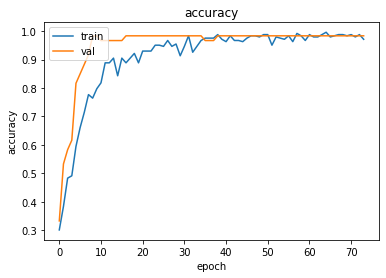

In [21]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('accuracy')
plt.show()

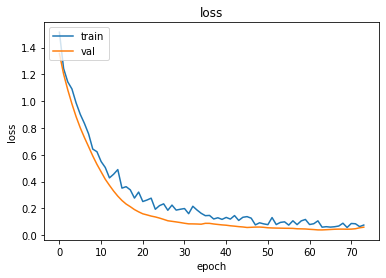

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('loss')
plt.show()

# Evaluation

In [23]:
test_model = tf.keras.models.load_model('/content/Ex3_PJ61403_DenseNet121_FocalLoss_model_Ver2.h5')

In [24]:
num_test_files = len(test_generator.filenames)

In [25]:
test_generator.reset()

In [26]:
test_labels = test_generator.classes
predictions = test_model.predict(test_generator, steps=num_test_files//test_generator.batch_size)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


## Confusion Matrix

### Without Normalize

Confusion matrix, without normalization
[[16  0  1  0]
 [ 0 15  0  0]
 [ 0  0 16  0]
 [ 0  0  0 15]]


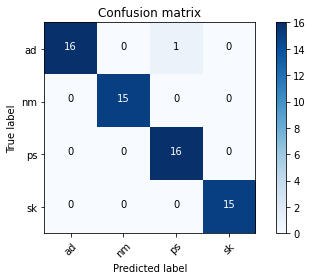

In [27]:
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

classes_names = ['ad', 'nm', 'ps', 'sk']

plot_confusion_matrix(cm, classes_names, False)

### With Normalize

Normalized confusion matrix
[[0.94117647 0.         0.05882353 0.        ]
 [0.         1.         0.         0.        ]
 [0.         0.         1.         0.        ]
 [0.         0.         0.         1.        ]]


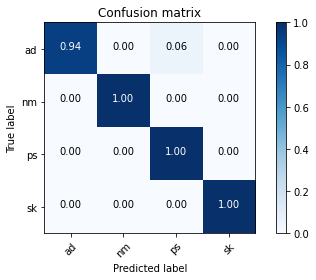

In [28]:
plot_confusion_matrix(cm, classes_names, True)

## Classification Report

In [29]:
y_pred = np.argmax(predictions, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_labels, y_pred))
print('Classification Report')
print(classification_report(test_labels, y_pred, target_names=classes_names))

Confusion Matrix
[[16  0  1  0]
 [ 0 15  0  0]
 [ 0  0 16  0]
 [ 0  0  0 15]]
Classification Report
              precision    recall  f1-score   support

          ad       1.00      0.94      0.97        17
          nm       1.00      1.00      1.00        15
          ps       0.94      1.00      0.97        16
          sk       1.00      1.00      1.00        15

    accuracy                           0.98        63
   macro avg       0.99      0.99      0.98        63
weighted avg       0.99      0.98      0.98        63



## TP FP FN TN

In [30]:
cm_2 = confusion_matrix(test_labels, y_pred)

### TP

In [31]:
TruePositive= np.diag(cm_2)

In [32]:
print(TruePositive)
sumTruePositive = sum(TruePositive)
print('Sum of True Positive: ', sumTruePositive)

[16 15 16 15]
Sum of True Positive:  62


### FP

In [33]:
FalsePositive = []
for i in range(NUM_CLASSES):
    FalsePositive.append(sum(cm_2[:,i]) - cm_2[i,i])

In [34]:
print(FalsePositive)
sumFalsePositive = sum(FalsePositive)
print('Sum of False Positive: ', sumFalsePositive)

[0, 0, 1, 0]
Sum of False Positive:  1


### FN

In [35]:
FalseNegative = []
for i in range(NUM_CLASSES):
    FalseNegative.append(sum(cm_2[i,:]) - cm_2[i,i])

In [36]:
print(FalseNegative)
sumFalseNegative = sum(FalseNegative)
print('Sum of False Negative: ', sumFalseNegative)

[1, 0, 0, 0]
Sum of False Negative:  1


### TN

In [37]:
TrueNegative = []
for i in range(NUM_CLASSES):
    temp = np.delete(cm_2, i, 0)   # delete ith row
    temp = np.delete(temp, i, 1)  # delete ith column
    TrueNegative.append(sum(sum(temp)))

In [38]:
print(TrueNegative)
sumTrueNegative = sum(TrueNegative)
print('Sum of True Negative: ', sumTrueNegative)

[46, 48, 46, 48]
Sum of True Negative:  188


### Check TP + FP +FN + TN = Test set

In [39]:
l = len(test_labels)
for i in range(NUM_CLASSES):
    print(TruePositive[i] + FalsePositive[i] + FalseNegative[i] + TrueNegative[i] == l)

True
True
True
True


## PYCM

In [40]:
!pip3 install pycm==3.0

In [41]:
from pycm import *

In [42]:
py_cm = ConfusionMatrix(actual_vector=test_labels, predict_vector=y_pred)

In [43]:
py_cm.classes

[0, 1, 2, 3]

In [44]:
py_cm.table

{0: {0: 16, 1: 0, 2: 1, 3: 0},
 1: {0: 0, 1: 15, 2: 0, 3: 0},
 2: {0: 0, 1: 0, 2: 16, 3: 0},
 3: {0: 0, 1: 0, 2: 0, 3: 15}}

In [45]:
print(py_cm)

Predict  0        1        2        3        
Actual
0        16       0        1        0        

1        0        15       0        0        

2        0        0        16       0        

3        0        0        0        15       





Overall Statistics : 

95% CI                                                            (0.95326,1.01499)
ACC Macro                                                         0.99206
ARI                                                               0.95491
AUNP                                                              0.98936
AUNU                                                              0.98999
Bangdiwala B                                                      0.96781
Bennett S                                                         0.97884
CBA                                                               0.97059
CSI                                                               0.97059
Chi-Squared                                             

### Average AUC

In [46]:
AV_AUC = (py_cm.AUC[0] + py_cm.AUC[1] + py_cm.AUC[2] + py_cm.AUC[3])/len(py_cm.AUC)

In [47]:
print('Average AUC: ', AV_AUC)

Average AUC:  0.9899874843554444


### Average Senstivity

In [48]:
AV_Sens = (py_cm.TPR[0] + py_cm.TPR[1] + py_cm.TPR[2] + py_cm.TPR[3])/len(py_cm.TPR)

In [49]:
print('Average Sensitivity: ', AV_Sens)

Average Sensitivity:  0.9852941176470589


### Average Specificity

In [50]:
AV_Spec = (py_cm.TNR[0] + py_cm.TNR[1] + py_cm.TNR[2] + py_cm.TNR[3])/len(py_cm.TNR)

In [51]:
print('Average Specificity: ', AV_Spec)

Average Specificity:  0.9946808510638298


## Grad-CAM

In [52]:
last_conv2d = 'conv5_block16_2_conv'

### AD

In [53]:
ad_img = '/content/PJ61403_DATA_split_50-25-25/crop_split_classes_data/val/ad/ad1.jpg'

Model prediction:
	ad             	(0)	with probability 1.000
	sk             	(3)	with probability 0.000
	ps             	(2)	with probability 0.000
	nm             	(1)	with probability 0.000
Explanation for 'ad'


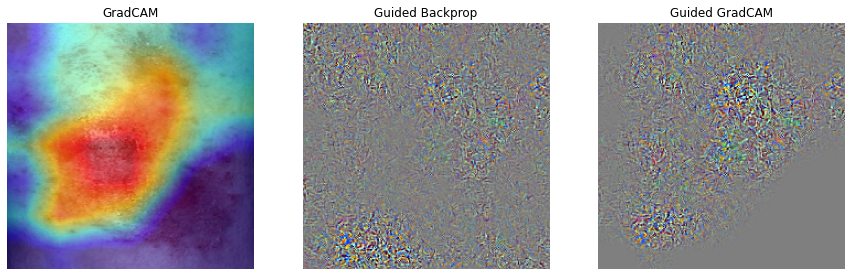

In [54]:
gradcam, gb, guided_gradcam = compute_saliency(test_model, test_model, ad_img, layer_name=last_conv2d)

### NM

In [55]:
nm_img = '/content/PJ61403_DATA_split_50-25-25/crop_split_classes_data/test/nm/nm4.jpg'

Model prediction:
	nm             	(1)	with probability 0.997
	ps             	(2)	with probability 0.002
	sk             	(3)	with probability 0.001
	ad             	(0)	with probability 0.000
Explanation for 'nm'


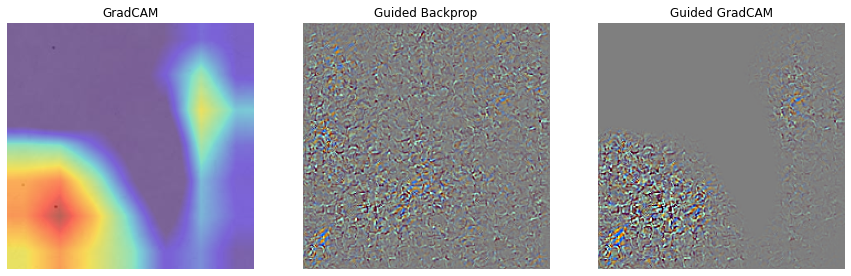

In [56]:
gradcam, gb, guided_gradcam = compute_saliency(test_model, test_model, nm_img, layer_name=last_conv2d)

### PS

In [57]:
ps_img = '/content/PJ61403_DATA_split_50-25-25/crop_split_classes_data/val/ps/ps57.jpg'

Model prediction:
	ps             	(2)	with probability 0.997
	sk             	(3)	with probability 0.001
	ad             	(0)	with probability 0.001
	nm             	(1)	with probability 0.000
Explanation for 'ps'


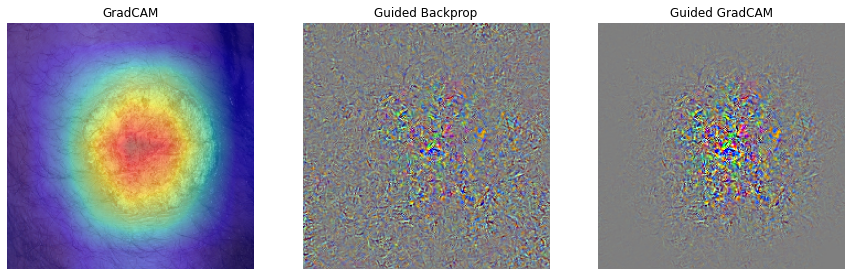

In [58]:
gradcam, gb, guided_gradcam = compute_saliency(test_model, test_model, ps_img, layer_name=last_conv2d)

### SK

In [59]:
sk_img = '/content/PJ61403_DATA_split_50-25-25/crop_split_classes_data/test/sk/sk4.jpg'

Model prediction:
	sk             	(3)	with probability 0.994
	ad             	(0)	with probability 0.003
	nm             	(1)	with probability 0.002
	ps             	(2)	with probability 0.001
Explanation for 'sk'


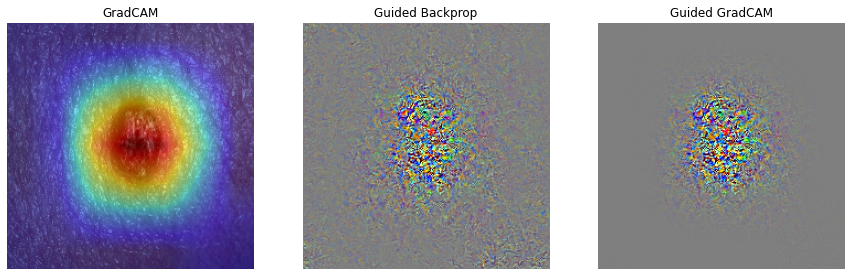

In [60]:
gradcam, gb, guided_gradcam = compute_saliency(test_model, test_model, sk_img, layer_name=last_conv2d)

# Download Model

In [61]:
from google.colab import files

In [62]:
files.download('/content/Ex3_PJ61403_DenseNet121_FocalLoss_model_Ver2.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>